# Binary classification

We will continue our classification problem from our EDA.

Recall our plot of the length and angle_from_snout features:

<AxesSubplot:xlabel='length', ylabel='angle_from_snout'>

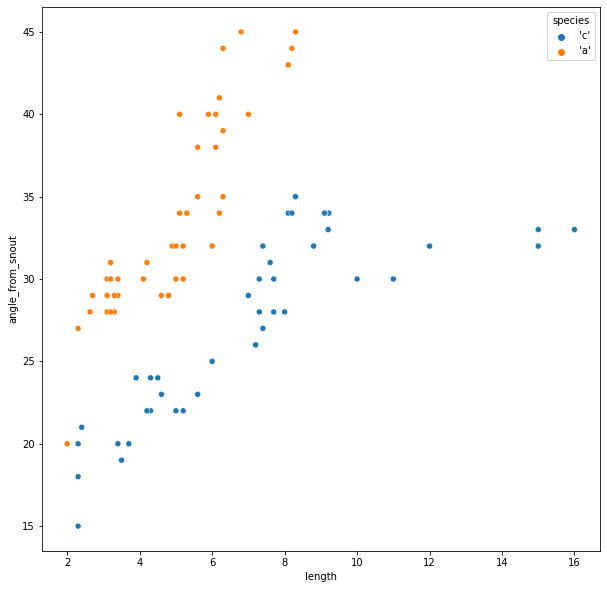

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from classifiers import models,validate
from train import gradient_descent


# Import pseudo data set
df = pd.read_csv('../../data/tabular/croc-aligator.csv')
training_data = pd.DataFrame({'length': df.length, 'angle_from_snout': df.angle_from_snout}).to_numpy()

# Map crocs, alligators to (-1,1) for classification
species =  pd.factorize(df.species)
vfunc = np.vectorize(lambda t: -1 if t == 0 else 1)
labels = vfunc(species[0])

#Visualize the data
_, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full')



## Choosing a model

Given our two features, how can we come up with a function $f$ that allows us to distinguish between crocs and alligators? Formally we want:
$f: \mathbb{R}^2 \rightarrow \{\text{alligator},\text{crocodile}\}$.

Well, if we look at the figure above, it seems like almost all points in that space can be separated by a slanted line anywhere around $20<y<25$. This seems like a reasonable thing to do,
if we were to draw a line in between the orange and blue points, we could claim that any point that falls above the line is an alligator and any point
that falls below the line is a crocodile.

Let us proceed with this discriminative line of reasoning.  So our task now is to come up with an equation for a line.
By visual inspection it looks like we have a slope of 1.5 and an intercept of 21. Let's see what this line looks like
over-laid on our scatter graph.


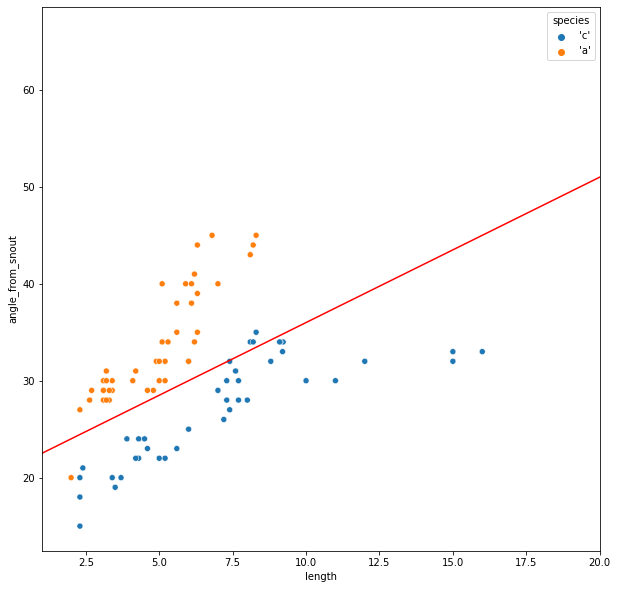

In [4]:

_, ax = plt.subplots(figsize=(10,10))
scatter = sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full', ax=ax)
ax.set_xlim(1, 20)

# Overlay line
def eq_of_line(x) -> float:
    return 1.5*x + 21

eq_of_line_vec = np.vectorize(eq_of_line)
domain = np.arange(0,30,.01)
scatter.plot(domain, eq_of_line_vec(domain), color='r',  )



### Linear Algebra

Okay, so we've come up with a line, but our task isn't quite complete, we still don't have an $f$ that classifies our data.
What we need is to somehow use our line to classify a point in feature space. The answer lies in an operation from linear algebra.


#### Vector space

We must first realize that the space in which is our features live in (aka feature space) is $\mathbb{R}^2$. It is perfectly reasonable to
treat every feature we have in $\mathbb{R}^2$ as vector. And therefore, we will treat $\mathbb{R}^2$ as a vector space over the reals, and we will
also consider the dot product and norm in this space as well. By allowing all this additional structure on our vector space, we will soon
see how we can leverage this features in useful ways.


#### Perpendicular vectors

Let us examine the equation of a line $2x + y = 0$ and use the following set of images to gain some intuition.

![alt text](../../images/perpendicular.png "Title")

An important result in linear algebra is that two vectors $a,b$ are perpendicular if their dot product is 0:

$a \cdot b = 0$.

Well algebraically if we take our equation of our line and re-write it like so:

$2x +y  =  \langle{2,1}\rangle * \langle{x,y}\rangle  = 0$

We can see some vectors popping out of our equation. That is $\langle{2,1}\rangle$ becomes a perpendicular vector to our line,
and any \langle{x,y}\rangle vector is represneted by our line.

Re-writing our equation in standard form allows us to easily read off this perpendicular vector.

$2x +y  = * \langle{2,1}\rangle = 0$

#### Dot products as a classification tool

![alt text](../../images/perpendicular-2.png "Title")

If we observe the diagram above and take the dot products of all the vectors relative to the normal vector, you will notice:

- Feature vectors that are below the line are negative
- Feature vectors that are above the line are positive

This is a very handy result. We can use the dot product to determine if our feature vectors are classified correctly!

The dot product between our normal vector and a feature vector can be represented as:

$\theta_1*x_1^{(i)} + \theta_2*x_2^{(i)}  + \theta_0 $ or more compactly $\theta \cdot x^{(i)} + \theta_0$.

And so :

$\theta \cdot x^{(i)} + \theta_0 > 0$ means that the feature vectors are above the line
$\theta \cdot x^{(i)} + \theta_0 < 0$ means the feature vectors are below the line
$\theta \cdot x^{(i)} + \theta_0 = 0$ means the feature vectors are on the line

Okay, it seems like we finally have a way to do classification! Recall that what we wanted was:

$f: \mathbb{R}^2 \rightarrow \{\text{alligator},\text{crocodile}\}$.

And what we need to do is:

1. Find the equation of a line
2. Compute the dot product of our normal vector a feature vector
3. Map the sign of the dot product to an alligator or crocodile

If we let $\text{alligator}$ represent the set of positive real numbers and $\text{crocodile}$ represent the set of negative real numbers,
then we finally have a rule for $f$. We can just check if $f$ gives us a positive or negative value!

One way we can get this result is if we let $f$ be $\hat y$ where  $\hat y = \text{sign}(\theta \cdot x^{(i)} + \theta_0) $



### Evaluating our model

#### Training

The above expression is great for building up intuition for how binary classification can work, but recall that we actually have data for this problem! We
need to somehow incorporate our observed values $y^{(i)} \in \text{Data}$ , so we can actually get a model $\theta$ to use to make future predictions. In other words,
we need to use our data, and find a way to evaluate any candidate models.

One quick observation we can make is that for any data point $x^{(i)}$ then a correct classification is just:

$(\theta * x^{(i)} + \theta_0) * y^{(i)}) > 0$.

And an incorrect classification:

$(\theta * x^{(i)} + \theta_0) * y^{(i)}) < 0$.

To see why this is, if we let $x^{(i)}$ be a data point that represents an alligator ($y^{(i)} = 1$), then
our classifier should return a positive value and hence we would have: $ \text{positive} * 1  > 0$

Alternatively if we let $x^{(i)}$ be a data point that represents a crocodile ($y^{(i)} = -1$), then
our classifier should return a negative value, and we would have: $ \text{negative} * -1  > 0$


#### 1/0 Loss and Hinge Loss

Now that we have a way to check evaluate our classification result, recall that we still need to use a loss function to assign a cost to a candidate model.
We will use our new expression as an input to our loss function $L(\theta * x^{(i)} + \theta_0) * y^{(i)})$

We have two possibilities: 1/0 loss and hinge loss.

The definition for the 1/0 loss is:

$
f(x) =
\begin{cases}
      1 &,  x \leq 0, \text{ Misclassified, loss} \\
      0 &,  x > 0, \text{ Classified correctly, no loss} \\
  \end{cases}
$

And some values:

$$
f(10) = 0
$$

$$
f(-1) = 1
$$

$$
f(-10) = 1
$$

$$
f(-100) = 1
$$

1/0 loss function doesn't give us a lot of information, it doesn't really help us quantify the negative consequence of an error.
Here hinge loss can help us here. The definition for the hinge loss is:

$
f(x) =
\begin{cases}
          1-x, & \text{ } x \leq 0, \text{ Misclassified, loss} \\
          0, & \text{ }  x > 0, \text{ Classified correctly, no loss} \\
  \end{cases}
$

And some values:

$$
f(10) = 0
$$

$$
f(-1) = 1
$$

$$
f(-10) = 10
$$

$$
f(-100) = 100
$$

Much better!

#### Dot products as a similarity tool

After looking at hinge loss, one might wonder what the large negative values as input actually represent. That is if our normal vector and a feature
vector return a very large negative value from: $(\theta * x^{(i)} + \theta_0) * y^{(i)})$, what does this tell us geometrically?  Well, aside from
$(\theta * x^{(i)} + \theta_0)$ returning a negative / positive value that we can use for classification, the dot product can be used to quantify 'similarity'.

How?

If we fix two feature vectors of the same magnitude, the feature vector that is closest to the normal vector will have the larger dot product.
This is a very useful property. In other words, this tells us that feature vectors that point in the same direction as normal vectors are the most similar.
And vectors that point in the opposite direction are the most dissimilar (larger negative dot product).

It is also worth noting that the magnitude affects the dot product. That is if we fix two feature vectors at the same angle, the length of the
larger feature vector will yield a higher dot product (with the normal vector). So really the most dissimilar vector we could have, is
a vector that is 180 degrees away from a normal vector and with a very large magnitude.



## Optimizing our model

We are finally ready to talk about optimization, now that we have our model and loss function established.
Even if we ignore $\theta_0$, in order to come up with an estimate of our model: $\theta$, we need $\theta_1*x_1^{(i)} + \theta_2*x_2^{(i)}$, we need to estimate 2 values!
So our objective function becomes:

$
J(\theta_1,\theta_2; Data)  = \frac{1}{n} \sum\limits_{i=0}^{n}
    \text{Loss}_h(\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)} ) * y^{(i)})
$

And we want: $\text{argmin}_{\theta_1, \theta_2} J(\theta_1,\theta_2; Data) $

#### Visualizing loss

Let us briefly run some values through $J$ to see what it looks like:



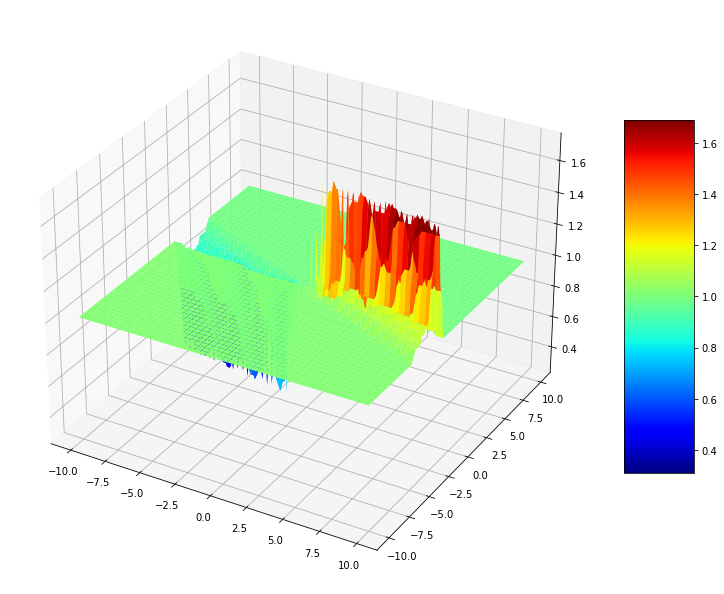

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

potential_theta_1_values =  np.arange(-10.0, 10.0, .1)
potential_theta_2_values = np.arange(-10.0, 10.0, .1)

def loss(t_1: float, t_2: float) -> float:
    model = models.BinaryClassifier(theta=np.array([t_1,t_2]))
    return validate.avg_loss(model, training_data, labels)
loss_f = np.vectorize(loss)

X, Y = np.meshgrid(potential_theta_1_values, potential_theta_2_values)
Z = np.array(loss_f(X,Y))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Gradient descent

We will use gradient descent here to search for our optimal value of theta. To do so we will need to compute... the gradient. Recall we have:

$
J(\theta_1,\theta_2; Data)  = \frac{1}{n} \sum\limits_{i=0}^{n}
    \text{Loss}_h(\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)}) * y^{(i)})
$

And we want:

$
\begin{align*}
\nabla J = \langle \frac{\partial J}{\partial \theta_1}  \frac{\partial J}{\partial \theta_2}  \rangle \\
\end{align*}
$

Let us first compute the partial derivatives for when $(\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)}) * y^{(i)}) < 0$

$$
\begin{align*}
 \frac{\partial }{\partial \theta_1} J &= \\
 \frac{\partial }{\partial \theta_1} 1- ((\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)}) * y^{(i)})) &= \\
 \frac{\partial u}{\partial v} * \frac{\partial v}{\partial \theta_1}  &= \text{ We-write using chain rule where } u = 1-v \text{ and } v = (\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)}) * y^{(i)})  \\
 - x_1 * y & \\
\end{align*}
$$

By a similar process we have $ \frac{\partial }{\partial \theta_2} J = - x_2 * y $


And when  $(\theta_1 \cdot x_1^{(i)} + \theta_2 \cdot x_2^{(i)}) * y^{(i)}) > 0$, for either $\theta_1$ or $\theta_2$ the derivative will be zero.

So in summary, when the input to our loss function is $< 0$ we have:

$
\begin{align*}
\nabla J = \langle \frac{\partial J}{\partial \theta_1}  \frac{\partial J}{\partial \theta_2}  \rangle  = \langle - x_1 * y, -x_2 * y \rangle \ \\
\end{align*}
$






